In [1]:
from itertools import product

In [2]:
from cpa_utils import *

# Elisabeth-b4 - Filter block

## Attacking the filter S-boxes

In [3]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"
locations_path = "correlation_locations_b4_two_last_rounds.pic"

In [4]:
seeds, traces, real_keys, correlation_locations = load_data(traces_path, key_path, locations_path)

In [5]:
def indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx: int, block_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    if not (0 <= block_target_idx < BLOCK_WIDTH_B4 - 1):
        return None

    key_space = (16,) if block_target_idx % 2 == 0 else (16, 16)
    location_mask_per_trace = np.zeros(total_traces.shape, dtype=bool)
    hypotheses = np.zeros(key_space + total_seeds.shape, dtype=int)

    if block_target_idx % 2 != 0:
        other_key_target_indices = np.zeros_like(total_seeds, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4

            # For now, we only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            # TO REMOVE IF BETTER IDEA IS FOUND
            #if block_idx == BLOCK_WIDTH_B4 - 1 or block_idx % 2 != 0:
            #if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 or block_idx != 4:
            if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != block_target_idx:
                continue
            # TO REMOVE IF BETTER IDEA IS FOUND

            if block_idx != BLOCK_WIDTH_B4 - 1:
                if block_idx % 2 == 0:
                    for k in range(16):
                        block = [0] * BLOCK_WIDTH_B4
                        block[block_idx] = (k + whitening[keyround_target_idx]) % 16

                        sbox_in = block[block_idx]
                        sbox_out = s_boxes_b4[block_idx][sbox_in]

                        hypotheses[k][i] = HW[sbox_out]
                else:
                    for k1, k2 in product(range(16), range(16)):
                        block = [0] * BLOCK_WIDTH_B4
                        block[block_idx] = (k1 + whitening[keyround_target_idx]) % 16
                        block[block_idx - 1] = (k2 + whitening[keyround_target_idx - 1]) % 16

                        sbox_in = (block[block_idx] + block[block_idx - 1]) % 16
                        sbox_out = s_boxes_b4[block_idx][sbox_in]
                        
                        hypotheses[k1][k2][i] = HW[sbox_out]
                    other_key_target_indices[i] = indices[keyround_target_idx - 1]
        
                location_mask_per_trace[i][locations[round_idx][block_idx]] = True
            else:
                raise ValueError("Should not happen")
                for i in range(3):
                    block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
                y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
                z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
                z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
                t_0 = (z[0] + z[1] + z[2]) % 16
                t_0 = (t_0 + block[block_idx - 1]) % 16
                sbox_out = s_boxes_b4[12][t_0]

                hypotheses[i] = HW[(block[block_idx] + sbox_out) % 16]
    
    if block_target_idx % 2 == 0:
        return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)]
    else:
        return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)], other_key_target_indices

In [6]:
def indices_locations_and_hyps_to_use_for_each_key_nibble(key_target_idx: int, block_target_indices: set[int], total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
    if any([not (0 <= b < BLOCK_WIDTH_B4 - 1) for b in block_target_indices]):
        return None

    return [indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx, b, total_seeds, total_traces, locations) for b in block_target_indices]

Key 0: 

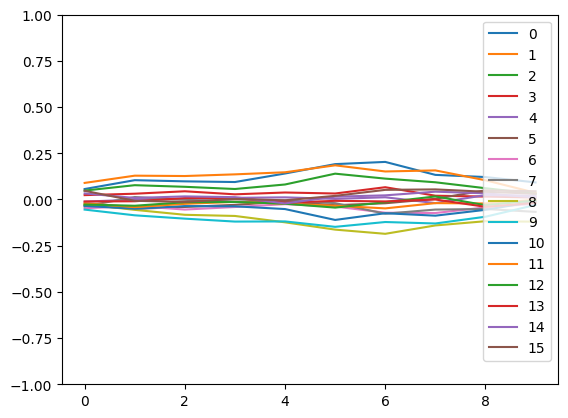

0[ 0.20326396  0.18478463  0.13967102  0.06631934  0.02367387  0.049582
 -0.02318375  0.01329467 -0.02554606 -0.02949109 -0.01031457 -0.00194402
  0.01637977  0.00796971  0.04217467  0.05451895]


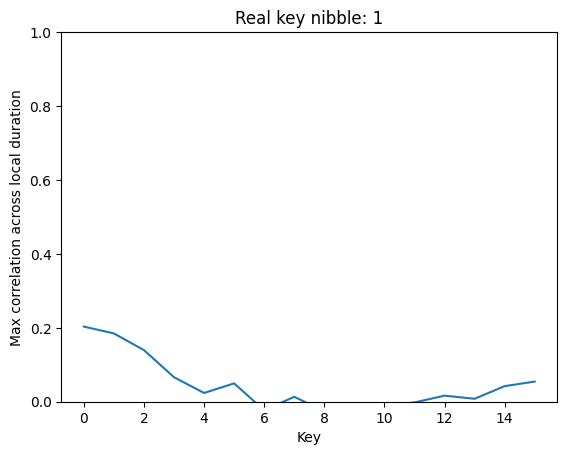

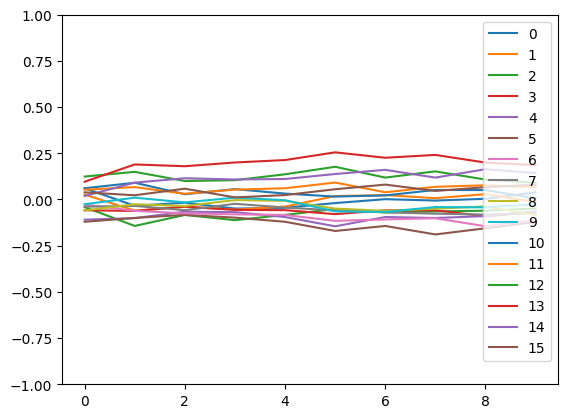

D[ 0.06036344  0.02900122 -0.04126094 -0.03866122 -0.0647356  -0.08330727
 -0.02740864 -0.02332176 -0.00345856  0.00984045  0.09054698  0.09163818
  0.17689461  0.25508061  0.16383642  0.08057643]


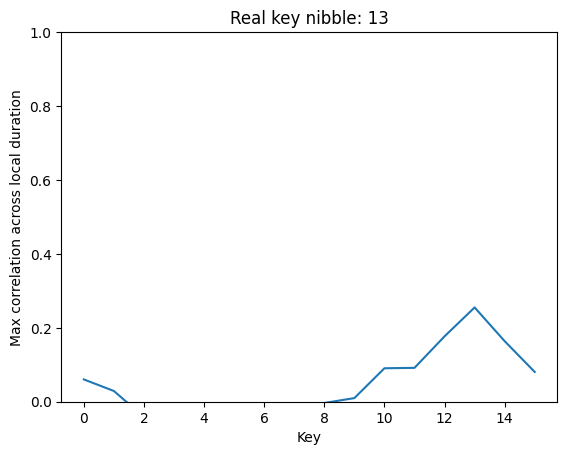

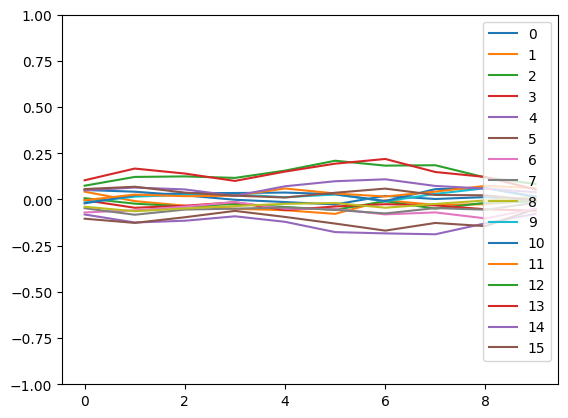

D[ 0.05132035  0.0421965   0.00697029 -0.00373783 -0.07754952 -0.05049781
 -0.01432239 -0.01718044  0.01336559  0.06101592  0.062257    0.07371523
  0.20964451  0.21918383  0.10921495  0.06893206]


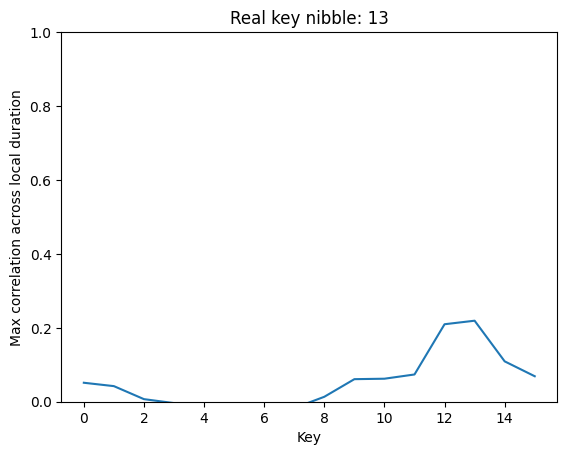

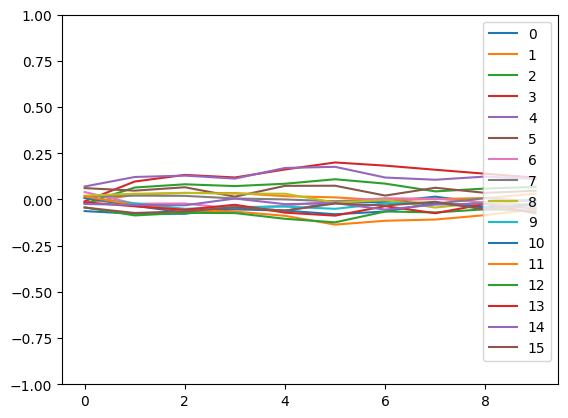

3[ 0.01524677  0.03546419  0.10944092  0.20031498  0.17671615  0.07438877
  0.04023657  0.02078881  0.03549134  0.00857508  0.00742633  0.01652475
 -0.04289449 -0.01516886  0.00515886 -0.01221667]


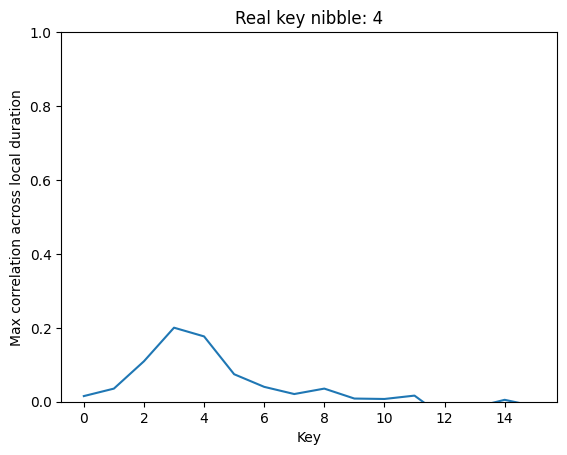

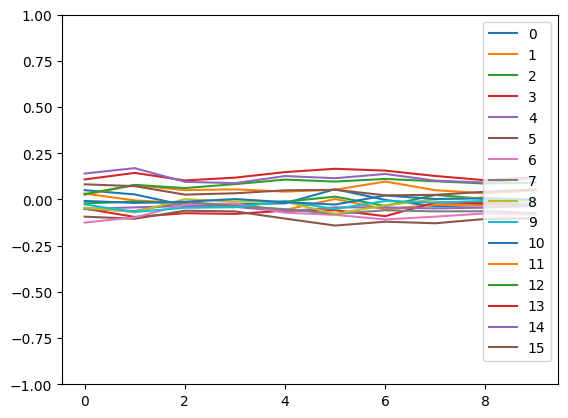

E[ 0.05575481  0.03205532  0.02468677 -0.01636271 -0.03458925 -0.06073342
 -0.02110902 -0.01331773  0.0109958  -0.00780898  0.02157443  0.09714628
  0.11117791  0.16622954  0.16957973  0.08190947]


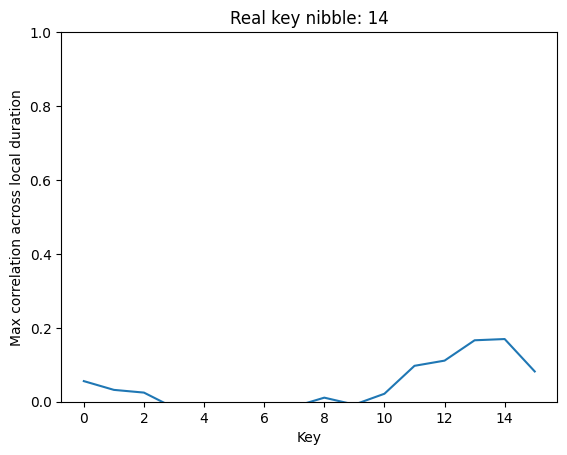

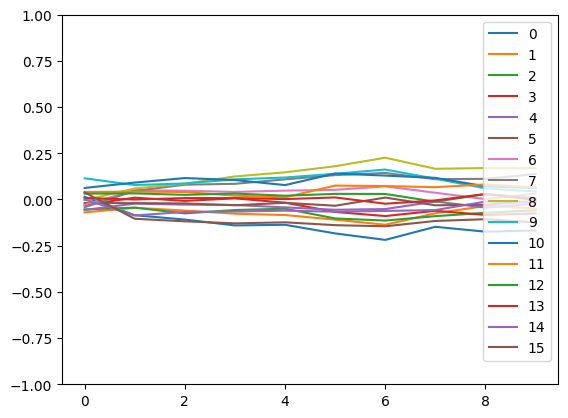

8[ 1.46787451e-02 -3.52367869e-02 -4.41291923e-02  9.76322778e-03
 -1.09678325e-02  1.02213547e-02  7.10250381e-02  1.43362767e-01
  2.26056369e-01  1.61995015e-01  1.40595742e-01  8.12789495e-02
  3.28895982e-02  2.96412307e-02 -2.24331916e-04  3.79777472e-02]


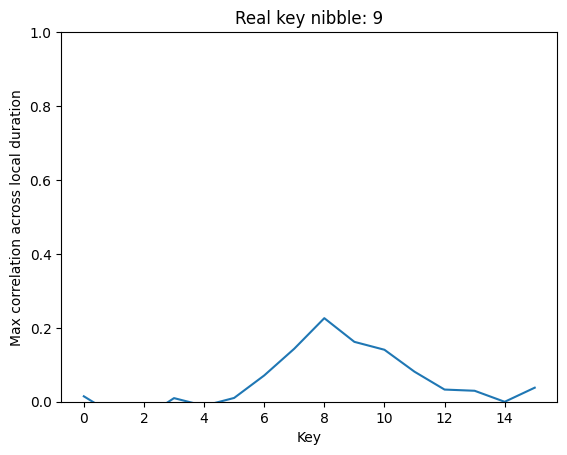

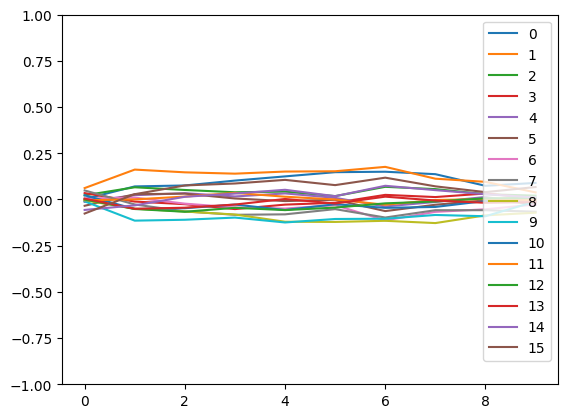

1[ 0.15013779  0.17648237  0.0685116   0.0346026   0.0341004   0.03165084
  0.01008061  0.04888997 -0.00488933 -0.01008461  0.02251149  0.03568251
  0.00839294  0.01528441  0.07408066  0.11802437]


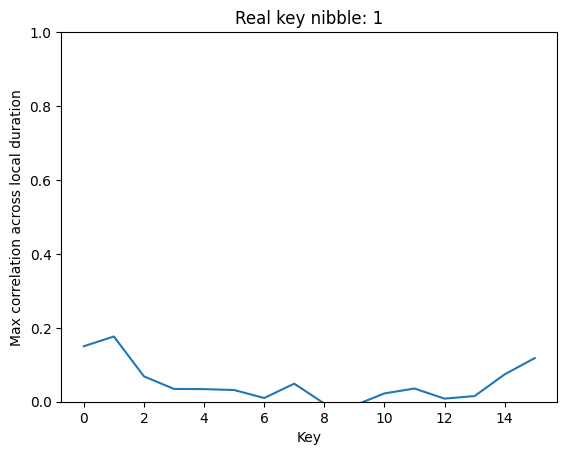

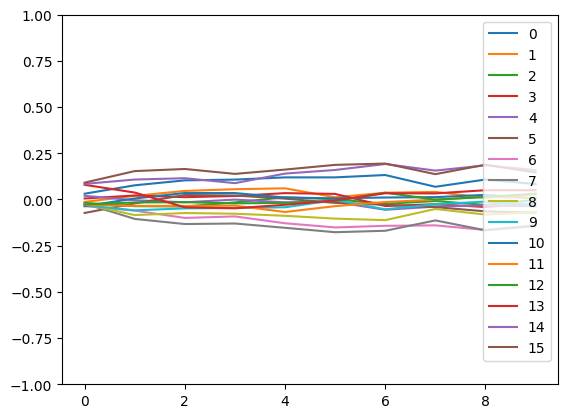

F[ 0.13234438  0.06032854  0.01197995  0.03437738  0.0198227   0.02413528
 -0.03590684 -0.02144356 -0.02544459 -0.00322215  0.03499387  0.01493933
  0.03668526  0.0794039   0.19189854  0.1943493 ]


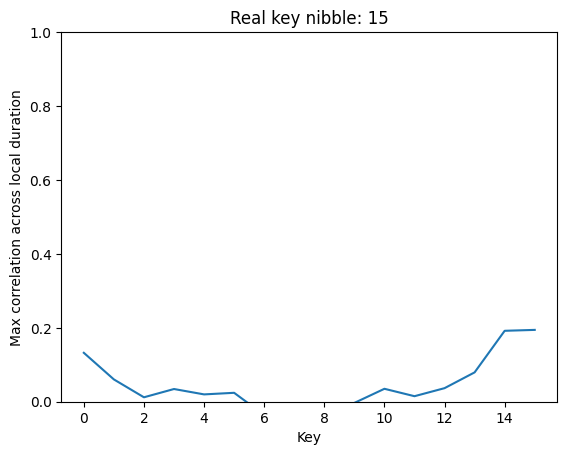

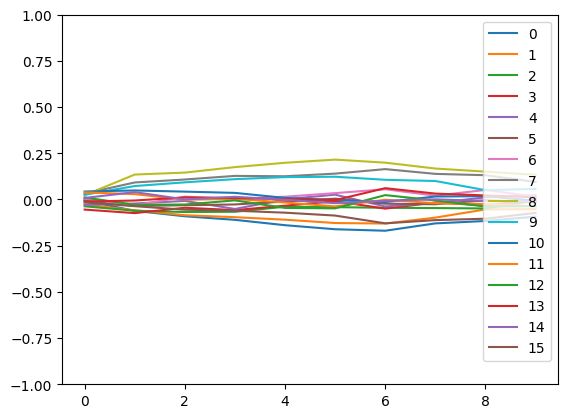

8[-0.00553251 -0.02719759 -0.00582065 -0.00066439  0.02590989  0.00430968
  0.05536465  0.16430022  0.21571448  0.12302661  0.04878489  0.03849684
  0.023629    0.06121694  0.03984215 -0.01615923]


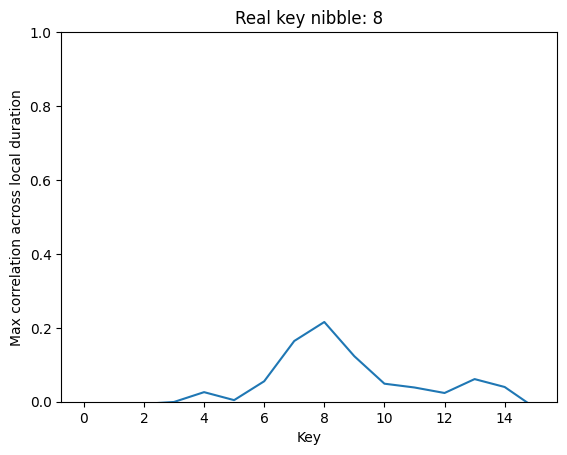

KeyboardInterrupt: 

In [7]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    visited = set()
    for j in range(reconstructed_keys.shape[1]):
        block_targets = [2]
        locs_and_hyps_per_block_target = indices_locations_and_hyps_to_use_for_each_key_nibble(j, block_targets, seeds[i], traces[i], correlation_locations)
        for k, block in enumerate(block_targets):
            if block % 2 == 0:
                selected_traces, hypotheses = locs_and_hyps_per_block_target[k]
                corrs = np.array([corr_coef_vectorized(hypotheses[l], selected_traces) for l in range(hypotheses.shape[0])])
            else:
                selected_traces, hypotheses, other_key_indices = locs_and_hyps_per_block_target[k]
                corrs = np.max([[corr_coef_vectorized(hypotheses[k1][k2], selected_traces) for k2 in range(hypotheses.shape[1])] for k1 in range(hypotheses.shape[0])], axis=1)

            for l in range(len(corrs)):
                plt.plot(corrs[l], label=str(l))

            plt.ylim([-1, 1])
            plt.legend()
            plt.show()
            
            max_corrs = np.max(corrs, axis=1)
            best_k = np.argmax(max_corrs)
            reconstructed_keys[i][j] = best_k

            if block % 2 != 0:
                pass
                #reconstructed_keys[i][other_key_indices[]]

            print(hex(best_k)[2:].upper(), end="")

            print(max_corrs)
            plt.plot(max_corrs)
            plt.xlabel("Key")
            plt.ylabel("Max correlation across local duration")
            plt.title(f"Real key nibble: {real_keys[i][j]}")
            plt.ylim([0, 1])
            plt.show()
    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()